In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display_matches(img1, img2, kp1, kp2, good_matches):
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    match_img_rgb = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 8))
    plt.imshow(match_img_rgb)
    plt.title("Matching Points")
    plt.axis("off")
    plt.show()

In [3]:
def stitch_images(img1, img2):
    
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #Converting Image 1 to GrayScale
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) #Converting Image 2 to GrayScale
    
    sift = cv2.SIFT_create() # Initialize SIFT detector
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None) #Compute Keypoints and Descriptors for image 1
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None) #Compute Keypoints and Descriptors for image 1
    
    bf = cv2.BFMatcher(cv2.NORM_L2)  # Initialize BFMatcher
    matches = bf.knnMatch(descriptors1, descriptors2, k=2) # knnMatch to finds the k best matches for each descriptor
    
    
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance] # Apply Lowe's ratio test to filter for good matches
    
    display_matches(img1, img2, keypoints1, keypoints2, good_matches)
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        # Extract location of good matches from both images
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        # Compute the homography matrix
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)  
        
        # Get image dimensions
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        
        # Compute the transformed corners of img1
        pts_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
        pts_img1_trans = cv2.perspectiveTransform(pts_img1, H)
        # Define corners of img2
        pts_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
        
        # Combine points from the transformed img1 and img2 to get overall bounds
        all_pts = np.concatenate((pts_img1_trans, pts_img2), axis=0)
        [x_min, y_min] = np.int32(all_pts.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(all_pts.max(axis=0).ravel() + 0.5)
        
        # Calculate the translation needed to shift all coordinates to positive space
        translation_dist = [-x_min, -y_min]
        H_translation = np.array([[1, 0, translation_dist[0]],
                                  [0, 1, translation_dist[1]],
                                  [0, 0, 1]])
        
        panorama_width = x_max - x_min
        panorama_height = y_max - y_min
        
        # Warp img1 with the combined homography and translation
        result = cv2.warpPerspective(img1, H_translation.dot(H), (panorama_width, panorama_height))
        
        # Paste img2 into the panorama canvas at the appropriate location
        result[translation_dist[1]:h2+translation_dist[1], translation_dist[0]:w2+translation_dist[0]] = img2
        
        return result
    else:
        print(f"Not enough matches found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None


In [4]:
def show_image(title, img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [5]:
def makePanorama(image_path_1, image_path_2):
    # Load your images
    img1 = cv2.imread(image_path_1)
    img2 = cv2.imread(image_path_2)
    # Display the original images
    show_image("Original Image 1", img1)
    show_image("Original Image 2", img2)
    # Stitch the images together
    panorama = stitch_images(img1, img2)
    if panorama is not None:
        show_image("Panorama", panorama)
        cv2.imwrite("panorama.jpg", panorama)

In [6]:
image_1 = "pan4_img1.jpg"
image_2 = "pan4_img2.jpg"

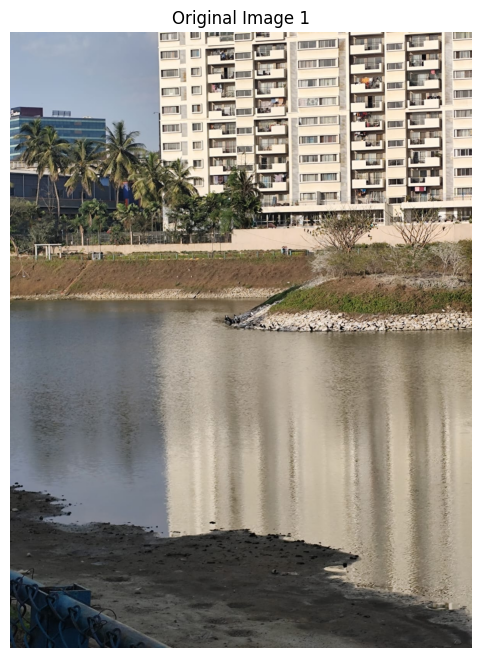

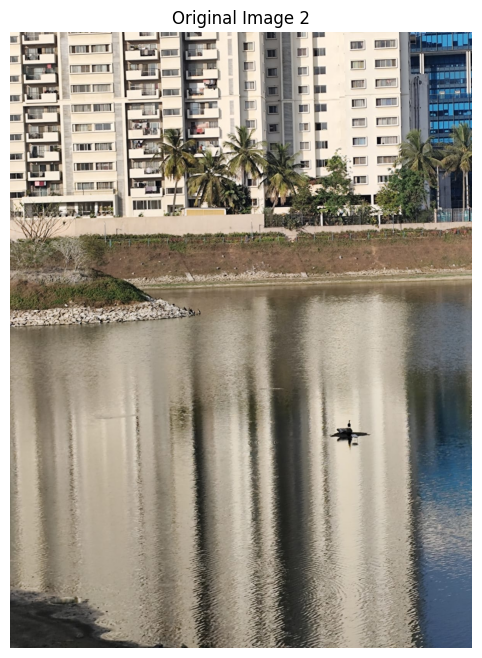

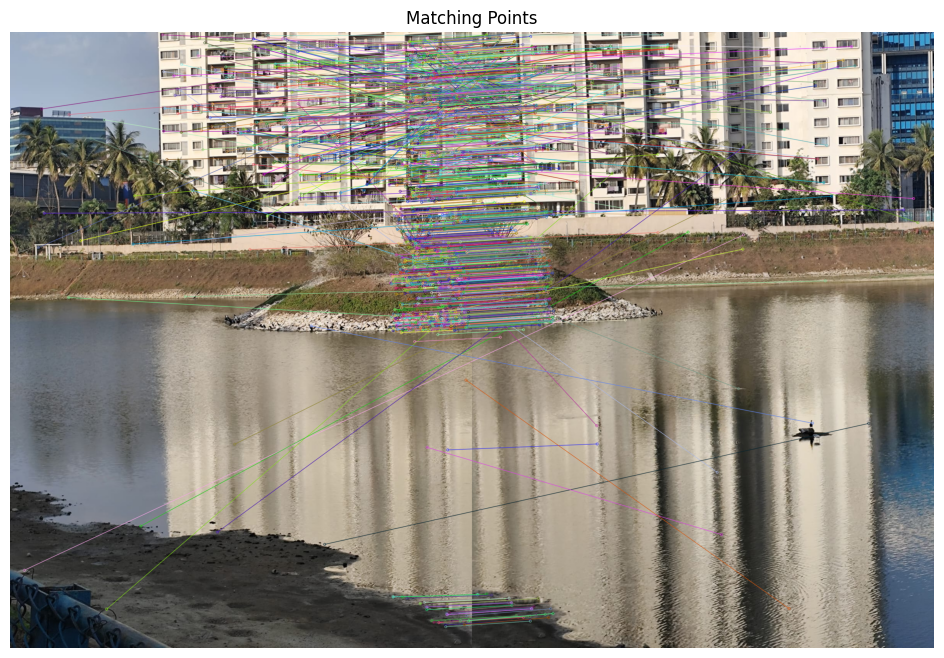

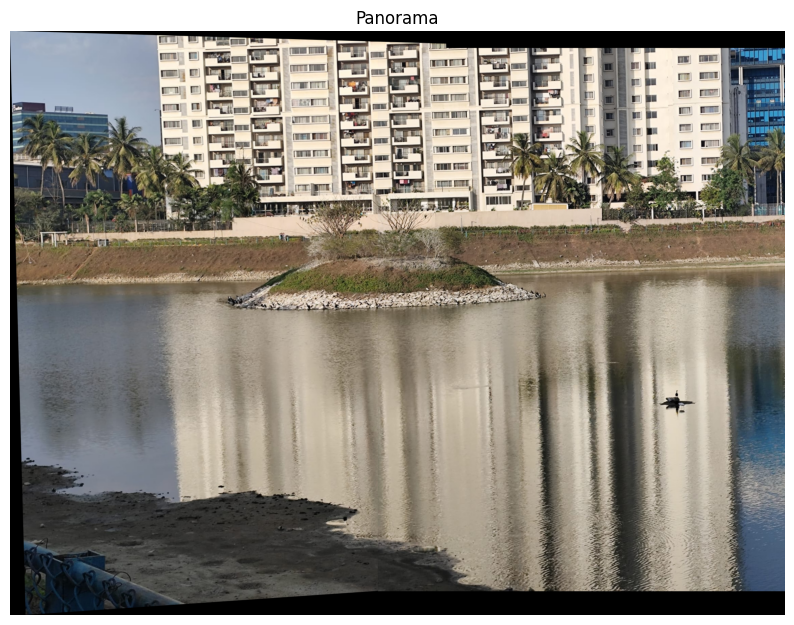

In [7]:
makePanorama(image_1, image_2)